In [1]:
# import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
train_df = pd.read_csv('train.csv')
print(train_df.head())

train_copy = train_df.copy()

   stock_id  date_id  seconds_in_bucket  imbalance_size  \
0         0        0                  0      3180602.69   
1         1        0                  0       166603.91   
2         2        0                  0       302879.87   
3         3        0                  0     11917682.27   
4         4        0                  0       447549.96   

   imbalance_buy_sell_flag  reference_price  matched_size  far_price  \
0                        1         0.999812   13380276.64        NaN   
1                       -1         0.999896    1642214.25        NaN   
2                       -1         0.999561    1819368.03        NaN   
3                       -1         1.000171   18389745.62        NaN   
4                       -1         0.999532   17860614.95        NaN   

   near_price  bid_price  bid_size  ask_price   ask_size  wap    target  \
0         NaN   0.999812  60651.50   1.000026    8493.03  1.0 -3.029704   
1         NaN   0.999896   3233.04   1.000660   20605.09  1.0 

In [3]:
# preprocessing the dataset

# removed rows in dataset where target values = 'NaN'
train_copy = train_copy.dropna(subset=['target'])
print(train_copy.isna().sum())

# removing unnecessary columns: 'row_id'
for col in train_copy.columns:
  if col == 'row_id':
    train_copy = train_copy.drop(col, axis=1)

stock_id                         0
date_id                          0
seconds_in_bucket                0
imbalance_size                 132
imbalance_buy_sell_flag          0
reference_price                132
matched_size                   132
far_price                  2894254
near_price                 2857092
bid_price                      132
bid_size                         0
ask_price                      132
ask_size                         0
wap                            132
target                           0
time_id                          0
row_id                           0
dtype: int64


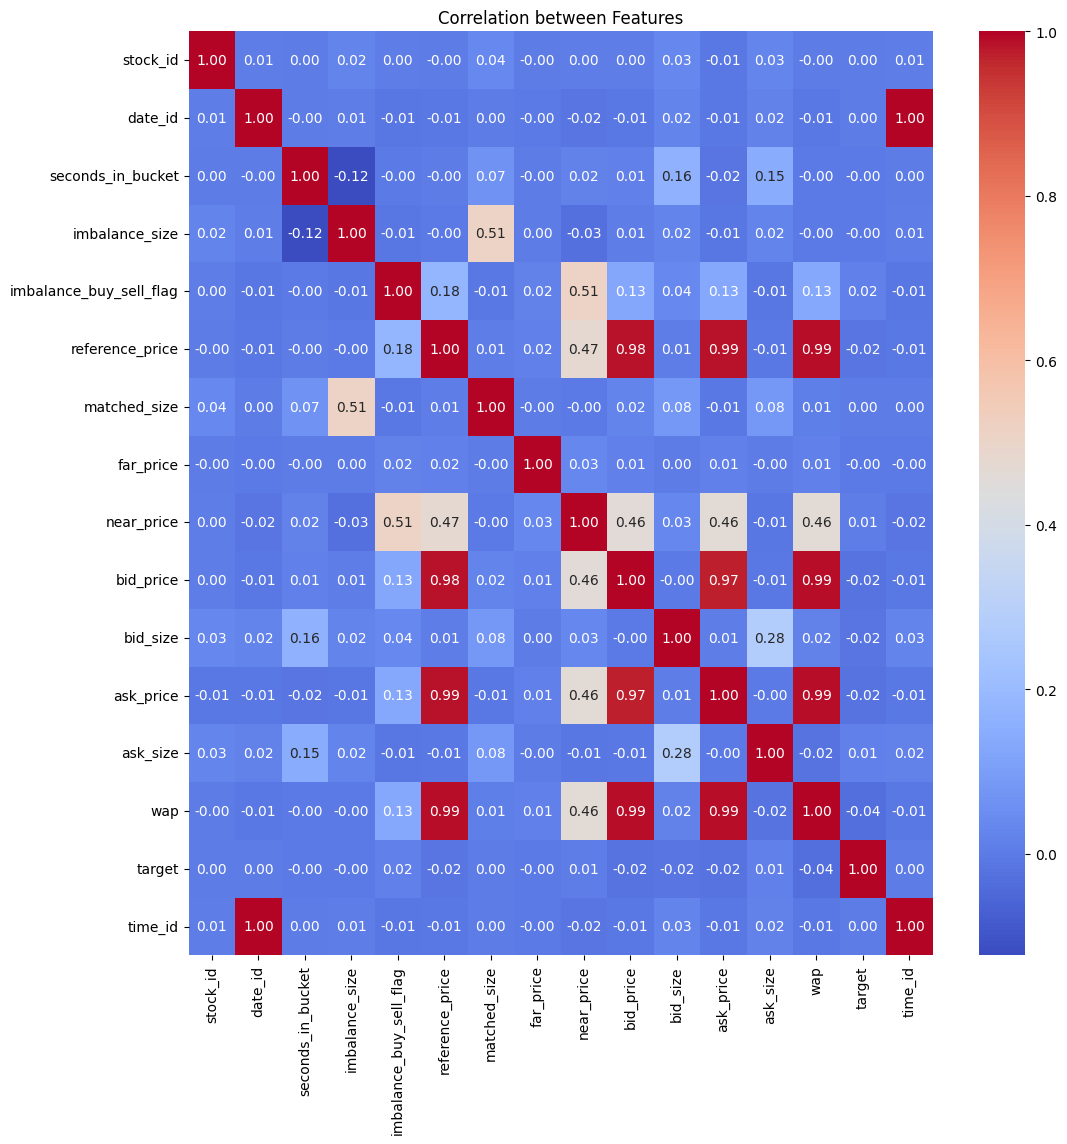

In [4]:
import seaborn as sns

# visualize correlation between features with a heatmap
corr = train_copy.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation between Features')
plt.show()

In [5]:
# baseline option: replacing 0 with NaN values
for col in train_copy.columns:
  if train_copy[col].isna().sum() > 0:
    train_copy[col].fillna(0, inplace=True)

print(train_copy.isna().sum())

stock_id                   0
date_id                    0
seconds_in_bucket          0
imbalance_size             0
imbalance_buy_sell_flag    0
reference_price            0
matched_size               0
far_price                  0
near_price                 0
bid_price                  0
bid_size                   0
ask_price                  0
ask_size                   0
wap                        0
target                     0
time_id                    0
dtype: int64


In [6]:
# implementing feature engineering by deriving original attributes to create new features
train_copy['bid_ask_price_spread'] = train_copy['ask_price'] - train_copy['bid_price']
train_copy['bid_ask_size_spread'] = train_copy['ask_size'] - train_copy['bid_size']
train_copy['bid_ask_price_ratio'] = train_copy['bid_price'] / train_copy['ask_price']
train_copy['far_near_price_ratio'] = train_copy['far_price'] / train_copy['near_price']
train_copy['wap_bid_price_ratio'] = train_copy['wap'] / train_copy['bid_price']
train_copy['wap_ask_price_ratio'] = train_copy['wap'] / train_copy['ask_price']
train_copy['imbalance_ratio'] = train_copy['imbalance_size'] / train_copy['matched_size']
train_copy['volume'] = train_copy['ask_size'] + train_copy['bid_size']

min_sizes = train_copy.groupby('stock_id')['bid_size'].min() + train_copy.groupby('stock_id')['ask_size'].min()
mean_sizes = train_copy.groupby('stock_id')['bid_size'].mean() + train_copy.groupby('stock_id')['ask_size'].mean()
max_sizes = train_copy.groupby('stock_id')['bid_size'].max() + train_copy.groupby('stock_id')['ask_size'].max()
std_sizes = train_copy.groupby('stock_id')['bid_size'].std() + train_copy.groupby('stock_id')['ask_size'].std()

train_copy['min_size'] = train_copy['stock_id'].map(min_sizes.to_dict())
train_copy['mean_size'] = train_copy['stock_id'].map(mean_sizes.to_dict())
train_copy['max_size'] = train_copy['stock_id'].map(max_sizes.to_dict())
train_copy['std_size'] = train_copy['stock_id'].map(std_sizes.to_dict())

for feat in train_copy.columns:
  if train_copy[feat].isna().sum() > 0:
    train_copy[feat].fillna(0, inplace=True)

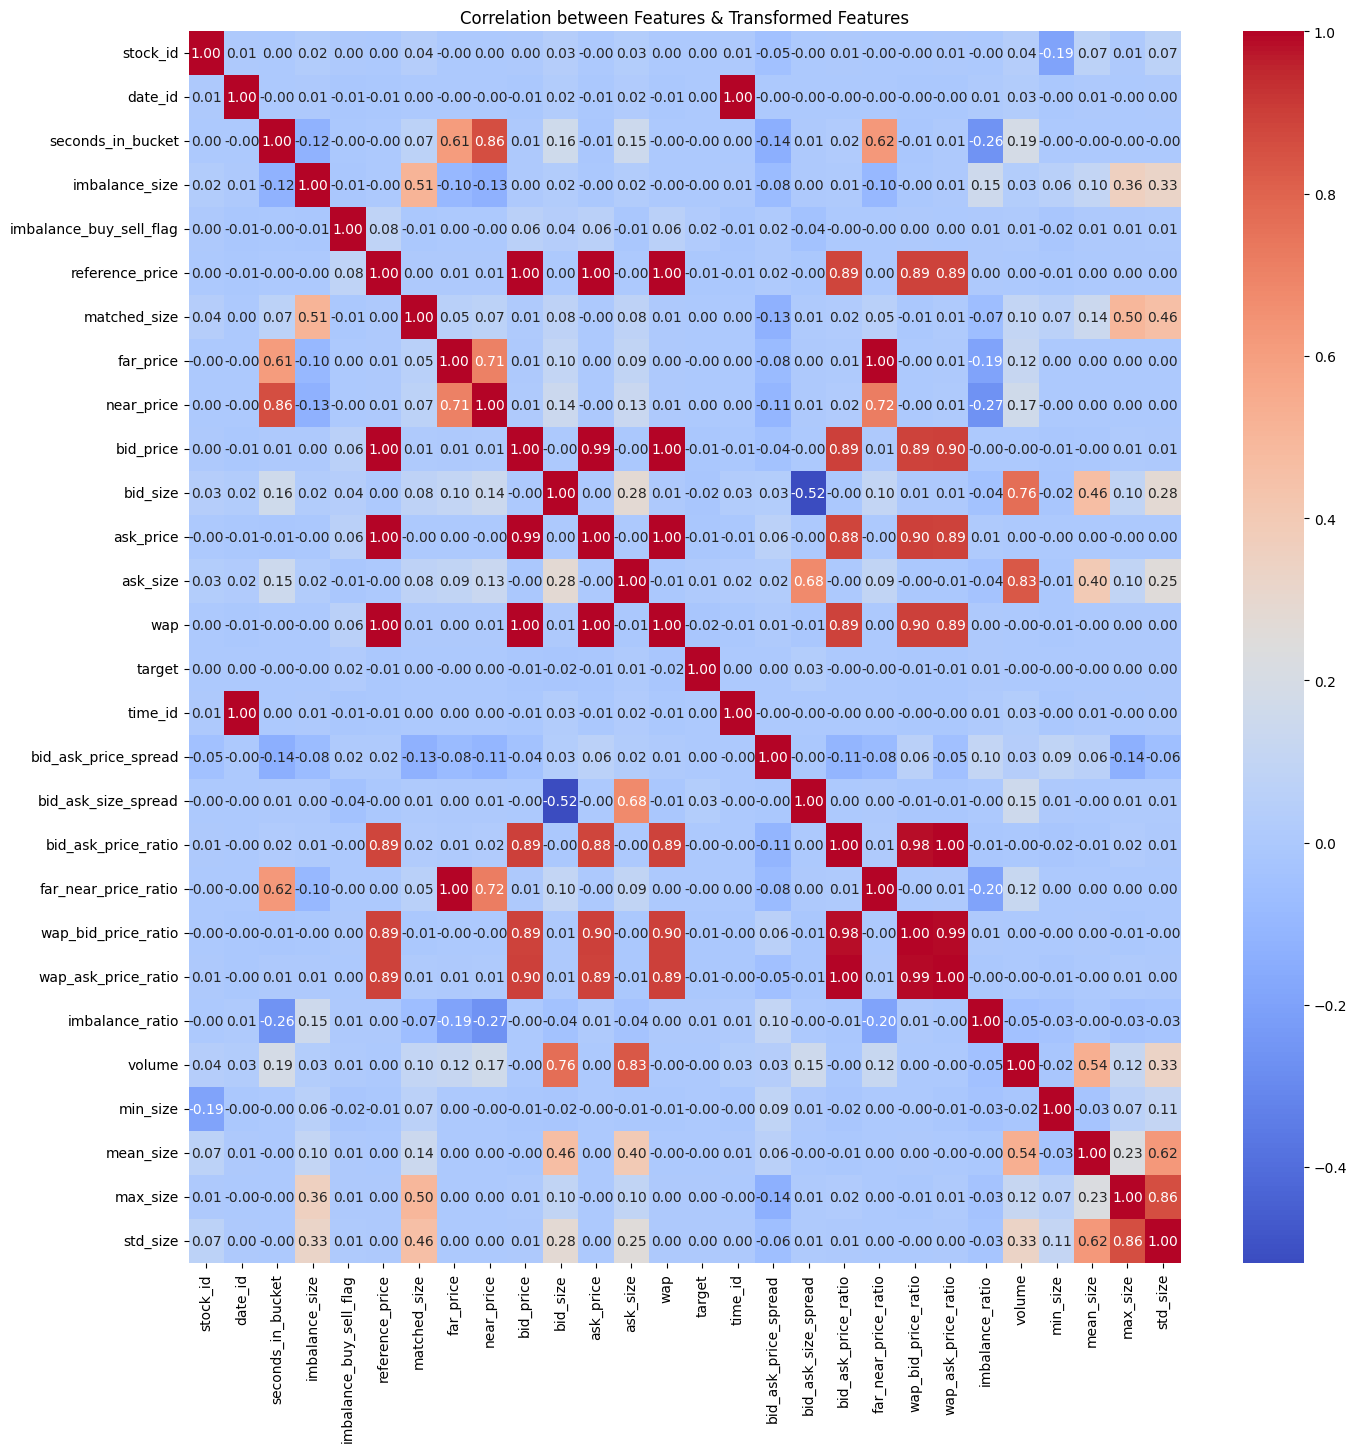

In [7]:
# generate new correlation heatmap with transformed attributes
trans_corr = train_copy.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(trans_corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation between Features & Transformed Features')
plt.show()

In [8]:
from sklearn.model_selection import train_test_split

# separate target column from train dataset
X = train_copy.drop(['target'], axis=1)
Y = train_copy['target']

# split into training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

[6.403931138962994, 6.324991269564869, 6.31752842773705, 6.3174248998246965, 6.317341435745716]


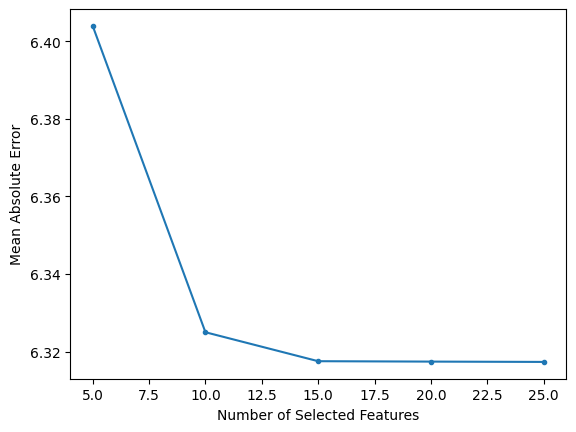

In [9]:
# implementing RFE with Linear Regression to select number of features to generate the lowest MAE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
features = range(5, len(X.columns), 5)
mae = []

for n in features:
  rfe = RFE(model, n_features_to_select=n)
  r_fit = rfe.fit(X_train, y_train)

  selected = X.columns[r_fit.support_]
  X_train_selected = X_train[selected]
  X_test_selected = X_test[selected]

  model.fit(X_train_selected, y_train)
  y_pred = model.predict(X_test_selected)
  mae.append(mean_absolute_error(y_test, y_pred))

print(mae)

# visualize loss of MAE according to number of selected features with a line graph
plt.plot(features, mae, marker='.')
plt.xlabel("Number of Selected Features")
plt.ylabel("Mean Absolute Error")
plt.show()

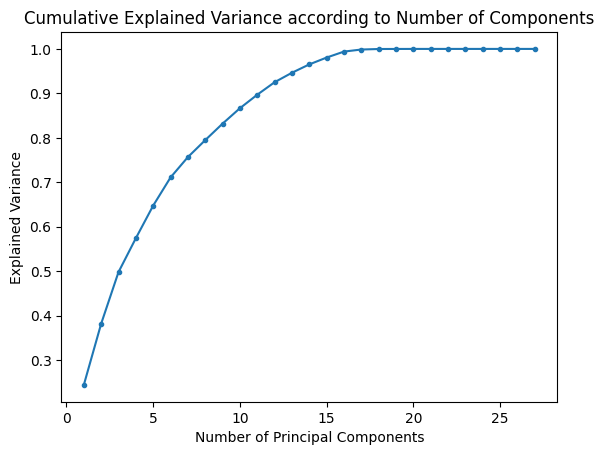

In [10]:
# implement PCA to determine number of components that generates the greatest variance of the dataset
scaler = StandardScaler()
stand = scaler.fit_transform(X_train)

pca = PCA()
pca.fit(stand)

# visualize cumulative variance according to the number of components
exp_var = pca.explained_variance_ratio_
plt.plot(range(1, len(exp_var) + 1), exp_var.cumsum(), marker='.')
plt.xlabel("Number of Principal Components")
plt.ylabel("Explained Variance")
plt.title("Cumulative Explained Variance according to Number of Components")
plt.show()

In [11]:
# results from RFE and PCA
n = 15
k = 12

# integrate PCA with RFE to determine the performance of the LinearRegression model
# the LinearRegression model was used because the target attribute is numerical, not categorical
comb_pca = PCA(n_components=k)
X_train_pca = comb_pca.fit_transform(X_train)
X_test_pca = comb_pca.transform(X_test)

model = LinearRegression()
comb_rfe = RFE(model, n_features_to_select=n)
comb_fit = comb_rfe.fit(X_train_pca, y_train)

selected = comb_pca.inverse_transform(X_train_pca[:, comb_fit.support_])

model.fit(selected, y_train)

selected_test = comb_pca.inverse_transform(X_test_pca[:, comb_fit.support_])
y_pred = model.predict(selected_test)

print(f"MAE using RFE & PCA: {mean_absolute_error(y_test, y_pred)}")

MAE using RFE & PCA: 6.403410521300074
